In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot

In [116]:
actions = pd.read_json('../exported/actions.json')
actions['_id'] = actions['_id'].apply(lambda x: x['$oid'])
actions['time'] = actions['time'].apply(lambda x: x['$date'])
actions['time'] = pd.to_datetime(actions['time'])


In [88]:
users = pd.read_json('../exported/users.json')
users['_id'] = users['_id'].apply(lambda x: x['$oid'])


In [89]:
actions['user_id'] = actions['user'].map(
    lambda userObject: userObject["$oid"], na_action='ignore')


In [90]:
actions = actions.merge(users, how='left', left_on='user_id', right_on='_id')


In [91]:
confessions = pd.read_json('../exported/confessions.json')


In [92]:
confessions['createdAt'] = confessions['createdAt'].apply(lambda x: x['$date'])
confessions['createdAt'] = pd.to_datetime(confessions['createdAt'])


In [93]:
confessions['_id'] = confessions['_id'].apply(lambda x: x['$oid'])


In [94]:
confessions['actions'] = confessions['actions'].apply(
    lambda x: pd.DataFrame(x))


In [95]:
confessions['actions'] = confessions['actions'].apply(
    lambda actions_df: actions_df.merge(actions, how='left', left_on='$oid', right_on='_id_x'))


In [96]:
active_moderators = actions['username'].dropna().unique()


In [97]:
moderator_actions_count = actions[['_id_x', 'username']].groupby(
    "username").count().reset_index()


In [98]:
moderator_actions_count = moderator_actions_count.sort_values(
    '_id_x', ascending=False)


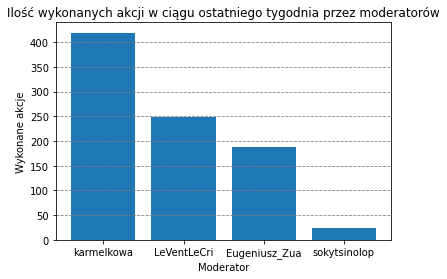

In [99]:
plot.grid(color='gray', linestyle='dashed', axis='y')
plot.bar(moderator_actions_count['username'],
         height=moderator_actions_count['_id_x'])
plot.ylabel('Wykonane akcje')
plot.xlabel('Moderator')
plot.title('Ilość wykonanych akcji w ciągu ostatniego tygodnia przez moderatorów')

plot.show()


In [100]:
# maybe filter out tags removed by moderator? where tag[1] == 0
confessions['tag_list'] = confessions.apply(
    lambda x: [tag[0] for tag in x['tags']], axis=1)


In [101]:
import string
tag_occurences_list = confessions['tag_list'].explode()
unique, counts = np.unique(tag_occurences_list, return_counts=True)
tag_occurences = list(zip(unique, counts))
tag_occurences = sorted(tag_occurences, key=lambda x: x[1])


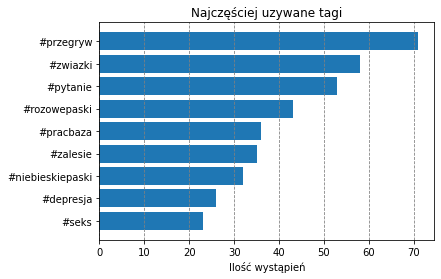

In [102]:
# TODO: https://stackoverflow.com/a/68107816/4183352
top_tags = tag_occurences[-10:]  # get most used tags
top_tags = top_tags[:-1]  # remove most used tag (#anonimowemirkowyznania)
tag_labes = [x[0] for x in top_tags]
tag_occurences_values = [x[1] for x in top_tags]

plot.grid(color='gray', linestyle='dashed', axis='x')

plot.barh(tag_labes, width=tag_occurences_values)
plot.title('Najczęściej uzywane tagi')
plot.xlabel('Ilość wystąpień')

plot.show()


In [213]:
def get_first_mod_action(actions_df):
    # find first index of action of type accept / decline
    idx = actions_df[(actions_df['type'] == 1) | (actions_df['type'] == 2)].first_valid_index()
    return actions_df.iloc[[idx]] if idx else None
confessions['1st_mod_action'] = confessions['actions'].map(get_first_mod_action).map(lambda x: x['time'].iloc[0], na_action='ignore')


In [216]:
confessions['reaction_time'] = confessions['1st_mod_action'].subtract(confessions['createdAt'])


0     0 days 11:58:01.341000
1     1 days 13:31:24.027000
2     1 days 12:53:56.975000
3     1 days 12:37:33.468000
4     1 days 10:14:25.794000
               ...          
451                      NaT
452                      NaT
453                      NaT
454                      NaT
455                      NaT
Length: 456, dtype: timedelta64[ns]